In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.layers import Dropout
from tensorflow.keras.models import Sequential
from keras import models
from tensorflow.keras.utils import plot_model
import zipfile
import warnings
from keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings('ignore')
os.environ["KMP_WARNINGS"] = "FALSE"

## Preprocessing

To process the images, we first have to convert them to a tensor format that can be consumed by the network. For them, we follow these steps:

- Read the image files.
- Decode the JPEG content to get an RGB grid of pixels.
- Convert them into floating point tensors.
- Scale the pixel values to the interval [0, 1].

In [2]:
train_path = pathlib.Path('Images/train')
val_path = pathlib.Path('Images/valid')
test_path = pathlib.Path('Images/test')

In [6]:
# Generates a Dataset from image files in a directory

train_dir = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(224,224),
    batch_size=256)

val_dir = tf.keras.utils.image_dataset_from_directory(
    val_path,
    image_size=(224,224),
    batch_size=256)

test_dir = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(224,224),
    batch_size=256)

Found 13572 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


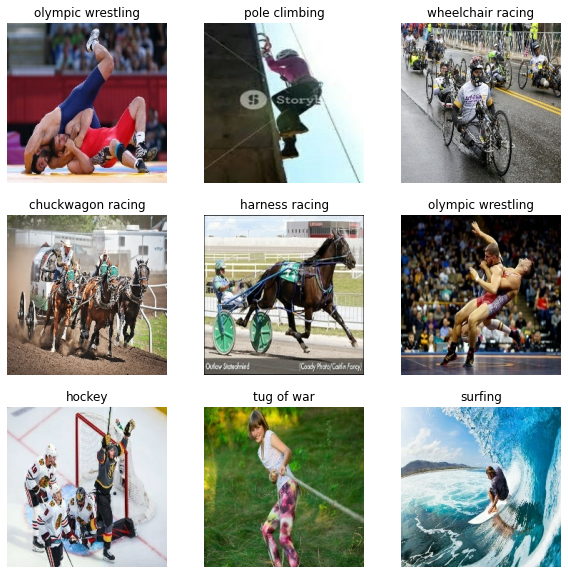

In [7]:
# Sample images

class_names = train_dir.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dir.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
# Allows you to create Python generators to convert disk images to tensors.
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224,224),
        batch_size=128,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=(224,224),
        batch_size=20,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224,224),
        batch_size=20,
        class_mode='categorical')

Found 13572 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [9]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (128, 224, 224, 3)
labels batch shape: (128, 100)


## Base Model

In [10]:
model = models.Sequential()
model.add(keras.Input(shape=(224, 224, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(1028, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(100, activation='softmax'))

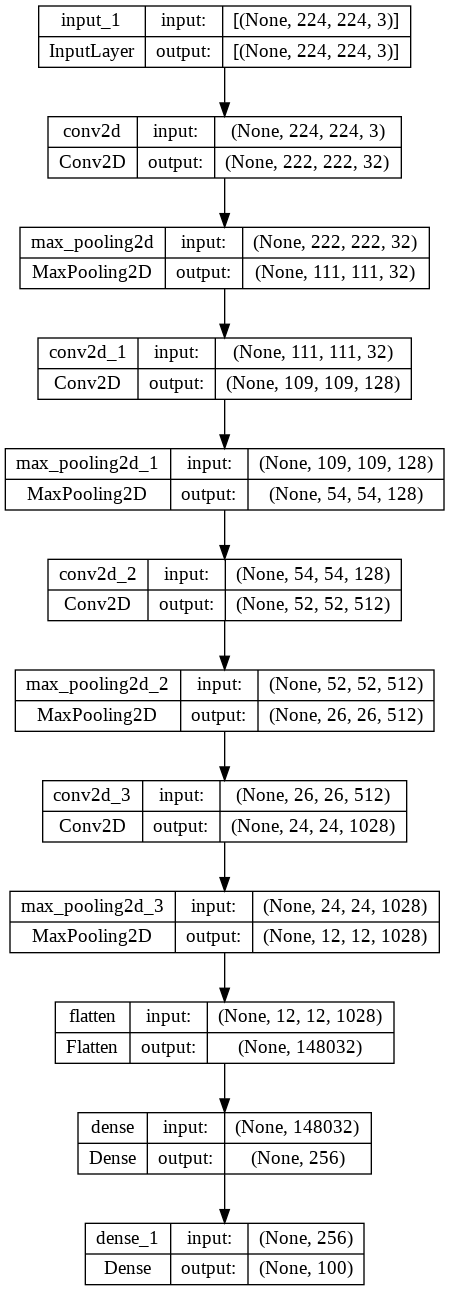

In [11]:
plot_model(model, show_shapes=True)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 512)       590336    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 512)      0

In [13]:
model.compile(optimizer="rmsprop",
 loss="categorical_crossentropy",
 metrics=["accuracy"])

In [14]:
history = model.fit_generator(
      train_generator,
      epochs=10,
      validation_data=validation_generator)

Epoch 1/10
107/107 [==============================] - 83s 599ms/step - loss: 6.7623 - accuracy: 0.0270 - val_loss: 4.3273 - val_accuracy: 0.0580
Epoch 2/10
107/107 [==============================] - 67s 620ms/step - loss: 3.9403 - accuracy: 0.1145 - val_loss: 3.4901 - val_accuracy: 0.1880
Epoch 3/10
107/107 [==============================] - 67s 624ms/step - loss: 3.0128 - accuracy: 0.2760 - val_loss: 2.7070 - val_accuracy: 0.3180
Epoch 4/10
107/107 [==============================] - 68s 633ms/step - loss: 2.1889 - accuracy: 0.4481 - val_loss: 2.5408 - val_accuracy: 0.3840
Epoch 5/10
107/107 [==============================] - 68s 631ms/step - loss: 1.3298 - accuracy: 0.6530 - val_loss: 2.9979 - val_accuracy: 0.3600
Epoch 6/10
107/107 [==============================] - 68s 632ms/step - loss: 0.6565 - accuracy: 0.8249 - val_loss: 3.4396 - val_accuracy: 0.3660
Epoch 7/10
107/107 [==============================] - 68s 632ms/step - loss: 0.3515 - accuracy: 0.9109 - val_loss: 4.0832 - val_ac

In [15]:
print("Accuracy test",model.evaluate(test_generator)[1])

25/25 [==============================] - 1s 48ms/step - loss: 5.9937 - accuracy: 0.3840
Accuracy test 0.3840000033378601


Based on the results from the first model, significant overfitting can be observed.

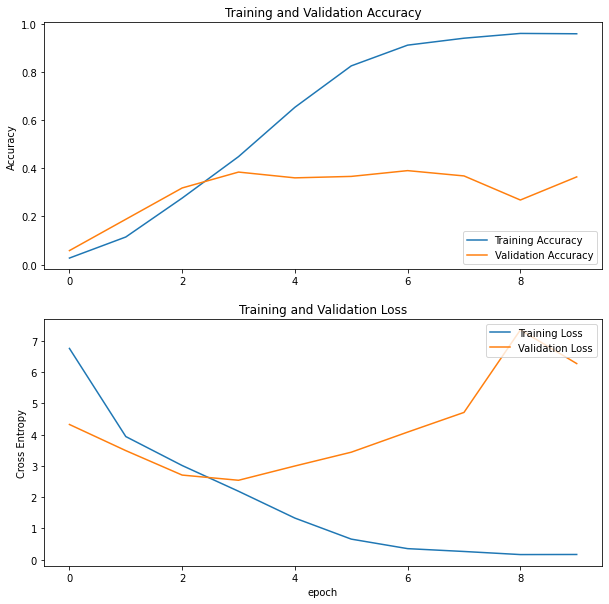

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Up to epoch 2, the accuracy and loss are similar in both train and test. From epoch 3 on, the overfitting starts to be evident, since the train accuracy starts to tend to 1 and in test it does not improve, while the loss curve from epoch 3 begins to decrease in train and increases in test.

## Base model with regularization and dropout

Based on the previous model where a marked overfitting is observed, I am going to apply some regularization layers (L1) and add some Dropout layers.

In [17]:
model_rd = models.Sequential()
model_rd.add(keras.Input(shape=(224, 224, 3)))
model_rd.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_rd.add(layers.MaxPooling2D((2, 2)))
model_rd.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer =tf.keras.regularizers.l1(l=0.001)))
model_rd.add(Dropout(0.4))
model_rd.add(layers.MaxPooling2D((2, 2)))
model_rd.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer =tf.keras.regularizers.l1(l=0.001)))
model_rd.add(layers.MaxPooling2D((2, 2)))
model_rd.add(layers.Conv2D(1028, (3, 3), activation='relu'))
model_rd.add(Dropout(0.4))
model_rd.add(layers.MaxPooling2D((2, 2)))
model_rd.add(layers.Flatten())
model_rd.add(layers.Dense(256, activation='relu'))
model_rd.add(layers.Dense(100, activation='softmax'))

In [18]:
model_rd.compile(optimizer="rmsprop",
 loss="categorical_crossentropy",
 metrics=["accuracy"])

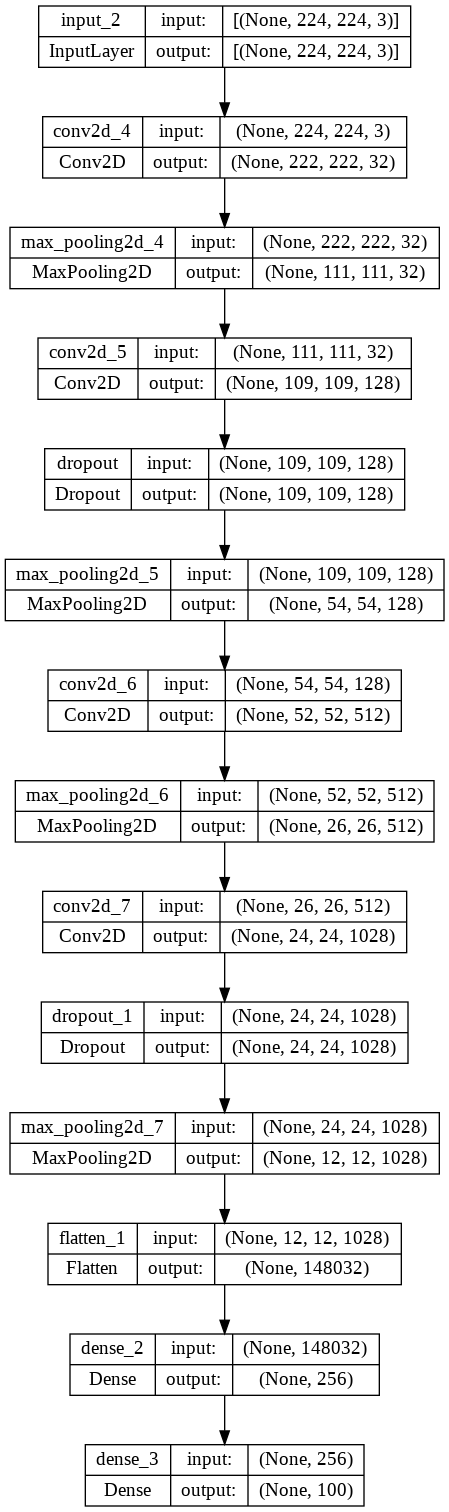

In [19]:
plot_model(model_rd, show_shapes=True)

In [20]:
history_rd = model_rd.fit_generator(
      train_generator,
      epochs=10,
      validation_data=validation_generator)

Epoch 1/10
107/107 [==============================] - 74s 679ms/step - loss: 8.6063 - accuracy: 0.0298 - val_loss: 5.3756 - val_accuracy: 0.0460
Epoch 2/10
107/107 [==============================] - 72s 674ms/step - loss: 4.5513 - accuracy: 0.1012 - val_loss: 4.4133 - val_accuracy: 0.0940
Epoch 3/10
107/107 [==============================] - 72s 670ms/step - loss: 3.9156 - accuracy: 0.1771 - val_loss: 4.2036 - val_accuracy: 0.1880
Epoch 4/10
107/107 [==============================] - 72s 667ms/step - loss: 3.4698 - accuracy: 0.2675 - val_loss: 3.8777 - val_accuracy: 0.2720
Epoch 5/10
107/107 [==============================] - 72s 667ms/step - loss: 3.0336 - accuracy: 0.3553 - val_loss: 3.4539 - val_accuracy: 0.3540
Epoch 6/10
107/107 [==============================] - 72s 668ms/step - loss: 2.5779 - accuracy: 0.4518 - val_loss: 3.2559 - val_accuracy: 0.4100
Epoch 7/10
107/107 [==============================] - 72s 669ms/step - loss: 2.1762 - accuracy: 0.5489 - val_loss: 3.2444 - val_ac

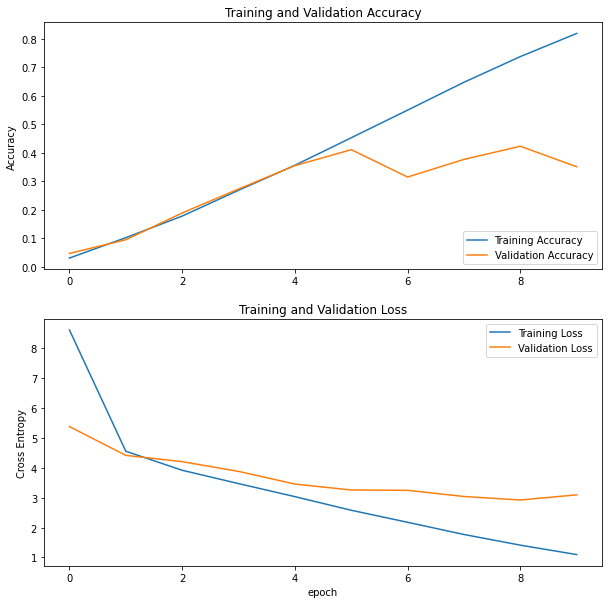

In [21]:
acc = history_rd.history['accuracy']
val_acc = history_rd.history['val_accuracy']

loss = history_rd.history['loss']
val_loss = history_rd.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Even applying some techniques to reduce overfitting, no noticeable improvements were observed. The other options would be to continue testing different combinations of models by reducing the number of layers and/or neurons or to change the model to improve its generalization power.

## Transfer Learning

Based on the above, we decided to implement a Transfer Learning model. For this particular case, we are going to try the MobileNetV2 model.

In [22]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_path,
        batch_size=128,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_path,
        batch_size=20,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_path,
        batch_size=20,
        class_mode='categorical')

Found 13572 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [23]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [24]:
#base_model.summary()

In [25]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(100, activation='relu', name='dense_1')(x)
x = tf.keras.layers.Dense(100, activation='relu', name='dense_2')(x)
outputs = tf.keras.layers.Dense(100, activation='softmax', name='final_layer')(x)
model_tl = tf.keras.Model(inputs, outputs)

In [26]:
model_tl.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

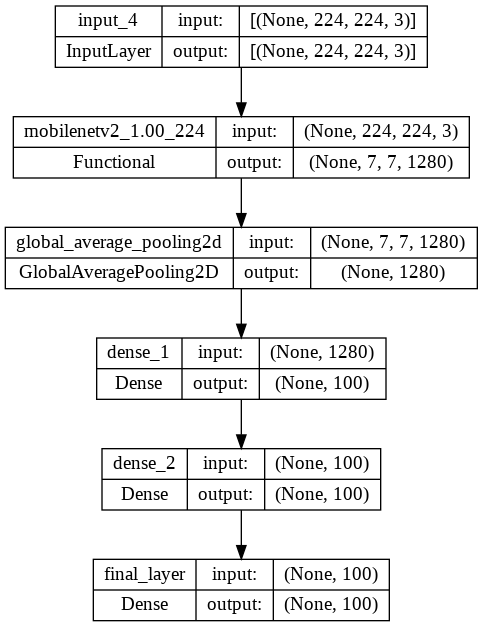

In [27]:
plot_model(model_tl, show_shapes=True)

In [28]:
model_tl.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 100)               128100    
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 final_layer (Dense)         (None, 100)               10100 

In [29]:
history_tl = model_tl.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator)

Epoch 1/10
107/107 [==============================] - 40s 338ms/step - loss: 2.5312 - accuracy: 0.4249 - val_loss: 1.1019 - val_accuracy: 0.7240
Epoch 2/10
107/107 [==============================] - 35s 323ms/step - loss: 0.9566 - accuracy: 0.7449 - val_loss: 0.6013 - val_accuracy: 0.8300
Epoch 3/10
107/107 [==============================] - 35s 322ms/step - loss: 0.6243 - accuracy: 0.8291 - val_loss: 0.4934 - val_accuracy: 0.8380
Epoch 4/10
107/107 [==============================] - 36s 331ms/step - loss: 0.4532 - accuracy: 0.8697 - val_loss: 0.3692 - val_accuracy: 0.8960
Epoch 5/10
107/107 [==============================] - 34s 322ms/step - loss: 0.3473 - accuracy: 0.9015 - val_loss: 0.3305 - val_accuracy: 0.8920
Epoch 6/10
107/107 [==============================] - 34s 319ms/step - loss: 0.2720 - accuracy: 0.9215 - val_loss: 0.2986 - val_accuracy: 0.8960
Epoch 7/10
107/107 [==============================] - 34s 319ms/step - loss: 0.2100 - accuracy: 0.9400 - val_loss: 0.3091 - val_ac

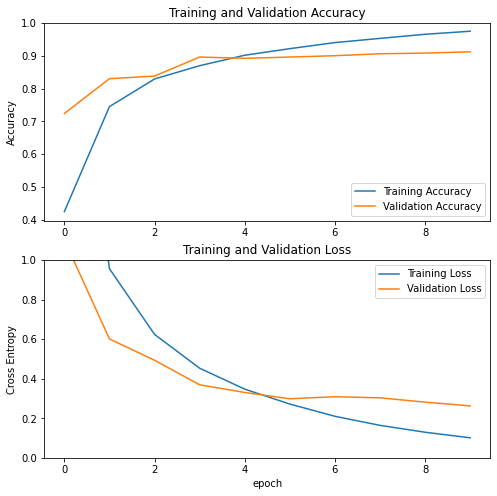

In [30]:
acc = history_tl.history['accuracy']
val_acc = history_tl.history['val_accuracy']

loss = history_tl.history['loss']
val_loss = history_tl.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

From the implementation of the MobileNetV2 model we see a remarkable improvement in the accuracy of the model, as well as a remarkable decrease in the loss function. The first model (the simplest one) had an accuracy of 36% and a loss value of 6 for the validation set after 10 epochs, while the last model (MobileNetV2) has an accuracy of 89% and a loss value of 0.35 under the same conditions.

## Transfer Learning with training layers

In [31]:
base_model_tl = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

for layer in base_model_tl.layers[:5]:
  layer.trainable=False

In [32]:
base_model_tl.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [33]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model_tl(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(100, activation='relu', name='dense_1')(x)
x = tf.keras.layers.Dense(100, activation='relu', name='dense_2')(x)
outputs = tf.keras.layers.Dense(100, activation='softmax', name='final_layer')(x)
model_tl_tr = tf.keras.Model(inputs, outputs)

In [34]:
model_tl_tr.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
model_tl_tr.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 100)               128100    
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 final_layer (Dense)         (None, 100)               1010

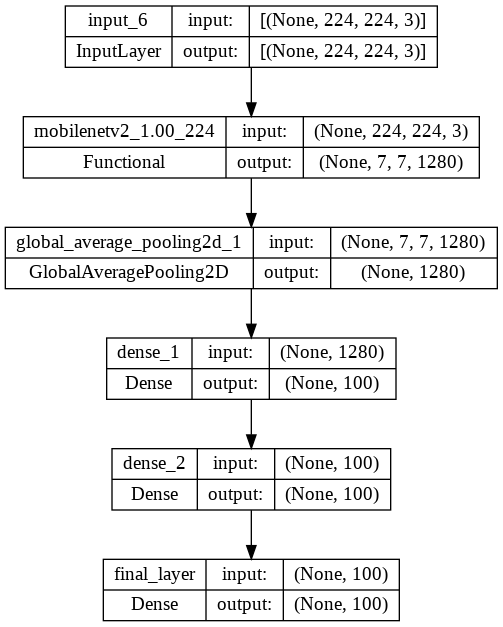

In [36]:
plot_model(model_tl_tr, show_shapes=True)

In [37]:
history_tl_tr = model_tl_tr.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator)

Epoch 1/10
107/107 [==============================] - 98s 824ms/step - loss: 1.8631 - accuracy: 0.5524 - val_loss: 11.8533 - val_accuracy: 0.0820
Epoch 2/10
107/107 [==============================] - 88s 818ms/step - loss: 0.6072 - accuracy: 0.8315 - val_loss: 11.0515 - val_accuracy: 0.1780
Epoch 3/10
107/107 [==============================] - 87s 815ms/step - loss: 0.3859 - accuracy: 0.8881 - val_loss: 25.2056 - val_accuracy: 0.0360
Epoch 4/10
107/107 [==============================] - 88s 819ms/step - loss: 0.3050 - accuracy: 0.9147 - val_loss: 21.9211 - val_accuracy: 0.0760
Epoch 5/10
107/107 [==============================] - 88s 817ms/step - loss: 0.2547 - accuracy: 0.9261 - val_loss: 25.5891 - val_accuracy: 0.0620
Epoch 6/10
107/107 [==============================] - 88s 818ms/step - loss: 0.2313 - accuracy: 0.9341 - val_loss: 34.9533 - val_accuracy: 0.0240
Epoch 7/10
107/107 [==============================] - 88s 818ms/step - loss: 0.2244 - accuracy: 0.9355 - val_loss: 31.6434 -

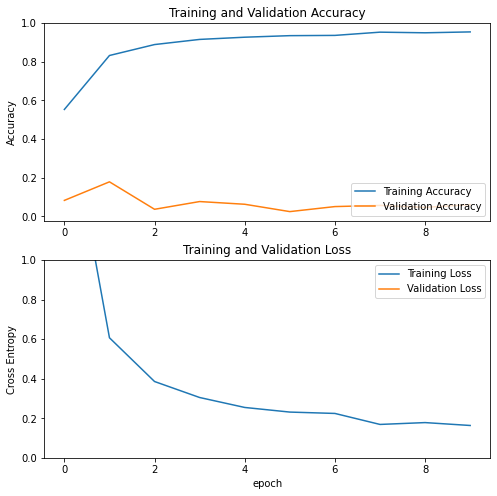

In [38]:
acc = history_tl_tr.history['accuracy']
val_acc = history_tl_tr.history['val_accuracy']

loss = history_tl_tr.history['loss']
val_loss = history_tl_tr.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

As a last step I decided to test the transfer learning model but training the layers, to see if we get an improvement and get closer to 100% in accuracy, but the reality is that we obtained a poor performance (we noticed the existence of overfitting, similar to the first model). We performed the test by freezing a larger number of layers and also freezing the last layers of the model, but the variations in the results were not significant.
As a final conclusion, we think that it would be better to use the Transfer Learning model without training the MobilNetV2 parameters, since it obtains better results for both accuracy and loss validation.